In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from TensorMesolve import *
from math import *
from cmath import exp
import qutip as q

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from PartialTrace import ptrace

In [4]:
Delta = 2*pi*10e3  #detuning
g = 2*pi*22.4385 #Rabi frequency
nu = 0.1087 #Lamb-Dicke parameter
Rabi = g**2/(Delta*4) #effective Rabi freq.
d = 2*nu*Rabi #detuning from secular freq(see next paragraph)
t = 2*pi/d #gate time
Nmod = 5 #number of fock states
ws = 2*pi*0.450 #secular freq.
n_th = 0 #initial phonon state 

In [5]:
#phonon destroy operator
a = q.destroy(Nmod)

#ions states - ground and excited
down = q.basis(3, 0)
up = q.basis(3, 1) 
ex = q.basis(3, 2)

#ions operators
matr_up = up.proj()
matr_down = down.proj()
matr_ex = ex.proj()

#Time-independent hamiltonians from latter formula
#H1 = nu*Rabi*(tensor(a, matr_up, qeye(3)) + tensor(a, qeye(3), matr_up))
#H2 = nu*Rabi*(tensor(a.dag(), matr_up, qeye(3)) + tensor(a.dag(), qeye(3), matr_up))

H1 = nu*Rabi*(q.tensor(a, matr_up, matr_down) - q.tensor(a, matr_down, matr_up) )
H2 = nu*Rabi*(q.tensor(a.dag(), matr_up, matr_down) - q.tensor(a.dag(), matr_down, matr_up)) 

H1 = tf.constant(H1.full(), dtype=tf.complex64)
H2 = tf.constant(H2.full(), dtype=tf.complex64)

In [6]:
#hadamard gate H
hadamard = 1 / sqrt(2.0) * q.Qobj([[1, 1, 0], [1, -1, 0], [0, 0, sqrt(2.0)]])
#pi/2 pulse
S = 1 / sqrt(2.0) * q.Qobj([[1, 1, 0], [-1, 1, 0], [0, 0, sqrt(2.0)]])
Bellstate = hadamard*down
# initial state
psi0 = q.tensor(q.basis(Nmod, n_th), Bellstate, Bellstate)
rho0 = q.tensor(q.fock_dm(Nmod, 0), Bellstate*Bellstate.dag(), Bellstate*Bellstate.dag()) 

psi0 = tf.constant(psi0.full(), dtype=tf.complex64)
rho0 = tf.constant(rho0.full(), dtype=tf.complex64)

In [7]:
def calc_timedepH(drive):
    Ht = drive[0,:,tf.newaxis,tf.newaxis]*H1[tf.newaxis] +\
         drive[1,:,tf.newaxis,tf.newaxis]*H2[tf.newaxis]
    return Ht

model = VirtQ(calc_timedepH)

In [8]:
rho0

<tf.Tensor: shape=(45, 45), dtype=complex64, numpy=
array([[0.25+0.j, 0.25+0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.25+0.j, 0.25+0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       ...,
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j]],
      dtype=complex64)>

In [30]:
model.set_initstate(psi0)

In [31]:
def calc_Phi3D(t):
    Drive = [[],[]]
    Drive[0].append(exp(-1j*d*t))                
    Drive[1].append(exp(1j*d*t))
    
    return np.asarray(Drive)

# Expectation values

In [32]:
phi_id = 1 / np.sqrt(2.0) * (q.tensor(q.basis(3, 0), q.basis(3, 0)) - 1j*q.tensor(q.basis(3, 1), q.basis(3, 1)))
dd = np.matrix(q.tensor(down, down).full())
uu = np.matrix(q.tensor(up, up).full())
ud = np.matrix(q.tensor(up, down).full())
du = np.matrix(q.tensor(down, up).full())
S2 = np.matrix(q.tensor(S, S).full())
target = np.matrix(phi_id.full())

In [33]:

def p00(state):
    return dd.getH()@S2@ptrace(np.asarray(state), [Nmod, 9], 0)@S2.getH()@dd
    
def p11(state):
    return uu.getH()@S2@ptrace(np.asarray(state), [Nmod, 9], 0)@S2.getH()@uu

def p10(state):
    return  ud.getH()@S2@ptrace(np.asarray(state), [Nmod, 9], 0)@S2.getH()@ud

def p01(state):
    return  du.getH()@S2@ptrace(np.asarray(state), [Nmod, 9], 0)@S2.getH()@du


def P(state):
    return [p00(state), p01(state), p10(state), p11(state)]

def inFid(state):
    return 1-target.getH()@S2@ptrace(np.asarray(state), [Nmod, 9], 0)@S2.getH()@target

def res(state):
    return np.abs(np.asarray([*P(state), inFid(state)]).reshape(5))


# TO DO

переписать функцию scanfidelity на свой лад

In [34]:
Nsteps = int(1e3) #number of steps for calculation
savestep = 10
timelist = np.linspace(0, 2*t, Nsteps) #array of time
model.set_timelist(timelist)
model.set_Lindblad_operators([])

In [35]:
output = model.solveSE(calc_Phi3D, progress_bar=True, e_ops = res,solver = 'RK4', savestep = 1)
output = np.array(output)

100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:08<00:00, 111.52it/s]


In [36]:
np.min(output[:, 4])

0.5000000000000002

In [37]:
tplot = np.linspace(0, 2*t, Nsteps) #array of time

In [26]:
def Plot_AllP(t, res, save = False, name = False):
    plt.figure(figsize= (10, 5))
    plt.plot(t, res[:, 0],  label = r'$\downarrow \downarrow$')
    plt.plot(t, res[:, 1],  label = r'$\downarrow \uparrow$',)
    plt.plot(t, res[:, 2],  label = r'$\uparrow \downarrow$',)
    plt.plot(t, res[:, 3],  label = r'$\uparrow \uparrow$',)
    plt.grid()
    plt.legend()
    #plt.plot(1e3*times, np.transpose(result.expect)[5], label = '1')
    plt.xlabel("Gate time (mus)")
    plt.ylabel("Level population")
    if save:
        print("Введите название сохраняемого файла: ")
        s = str(input())
        plt.savefig(s+ ".png")
    


In [38]:
def Fid_plot(t, res, save = False):
    plt.figure(figsize= (10, 5))

    plt.plot(t, res[:, 4])
    plt.grid()
    plt.xlabel("Gate time (mus)")
    plt.ylabel("Fidelity")
    if save:
        print("Введите название сохраняемого файла фиделити: ")
        s = str(input())
        if s!= '-':
            plt.savefig(s+ ".pdf")

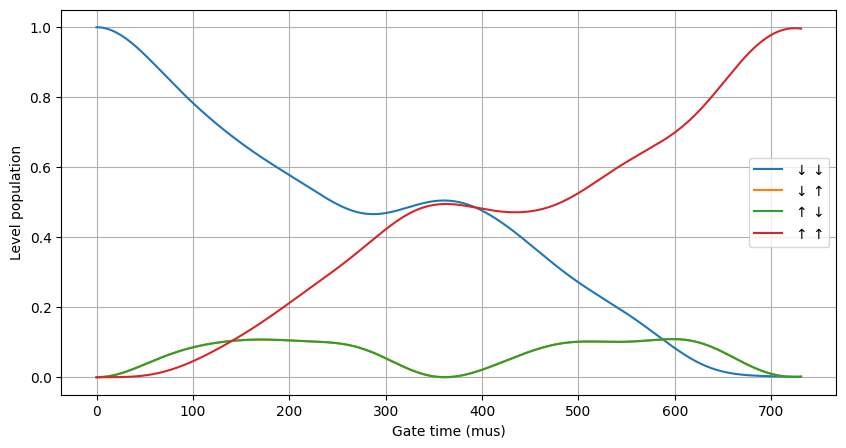

In [39]:
Plot_AllP(tplot, output)

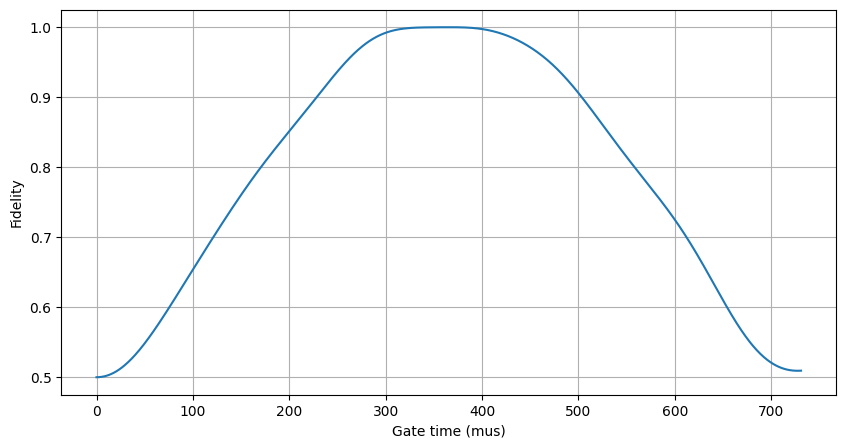

In [40]:
Fid_plot(tplot, output)

In [20]:
shape(psilist)

NameError: name 'shape' is not defined

In [ ]:
psilist[0, 0]

In [ ]:
q.Qobj(ptrace(np.asarray(initstate), [5, 9], 0))

In [ ]:
initstate.shape